In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

def date2int(date_obj):
    string = str(date_obj)
    return int("".join(string.split(" ")[0].split("-")))

def delete_zero(df):
    for i in df:
        df[i] = df[i].fillna(0)
        if (df[i] == 0).all():
            del df[i]
    return df

In [2]:
df_5_13 = pd.read_csv("./Data/df_5_13.csv", index_col=0, dtype={"date": int})
df_10_20 = pd.read_csv("./Data/df_10_20.csv", index_col=0, dtype={"date": int})
df_20_50 = pd.read_csv("./Data/df_20_50.csv", index_col=0, dtype={"date": int})
df_50_100 = pd.read_csv("./Data/df_50_100.csv", index_col=0, dtype={"date": int})
df_index = pd.read_csv("./Data/future_index.csv", index_col=0, dtype={"data": int})
df_index = df_index[(df_index["date"] >= 20070104) & (df_index["date"] <= 20180503)]

In [3]:
NPV_df = df_5_13.iloc[:, 1:].copy()
NPV_df = NPV_df / 1e8
NPV_df = delete_zero(NPV_df)
TOTAL_TYPE = NPV_df.shape[1]
positions = {}

In [4]:
positions["dgg"] = np.ones_like(NPV_df.iloc[:, 1:])

In [5]:
total_npv = NPV_df.sum(1).cumsum() / TOTAL_TYPE

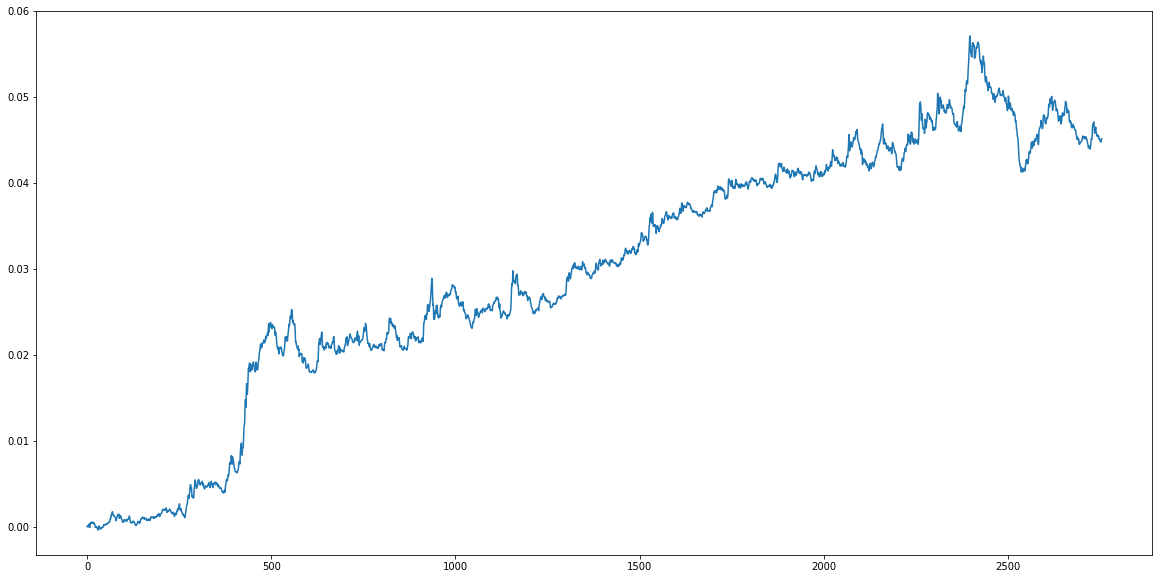

In [6]:
total_npv.plot(figsize=(20, 10))

In [7]:
H = 20
R = 50

In [8]:
# 使用历史波动率
weight = np.zeros_like(NPV_df)
changed = False

for idx in range(len(NPV_df) - H):
    if idx < R:
        continue
    
    if idx % H == 0:
        vol = NPV_df.iloc[idx - R : idx, :].std(axis=0)
        this_weight = (1 / vol) / sum(1 / vol)
        
        if this_weight.hasnans:
            this_weight = np.ones((1, TOTAL_TYPE)) / TOTAL_TYPE
        elif not changed:
            print("change to vol mode at:", idx)
            changed = True
        weight[idx : idx + H, :] = this_weight

positions["bdlds"] = weight / weight.mean()
total_npv = (positions["bdlds"] * NPV_df).sum(1).cumsum()

('change to vol mode at:', 2020)


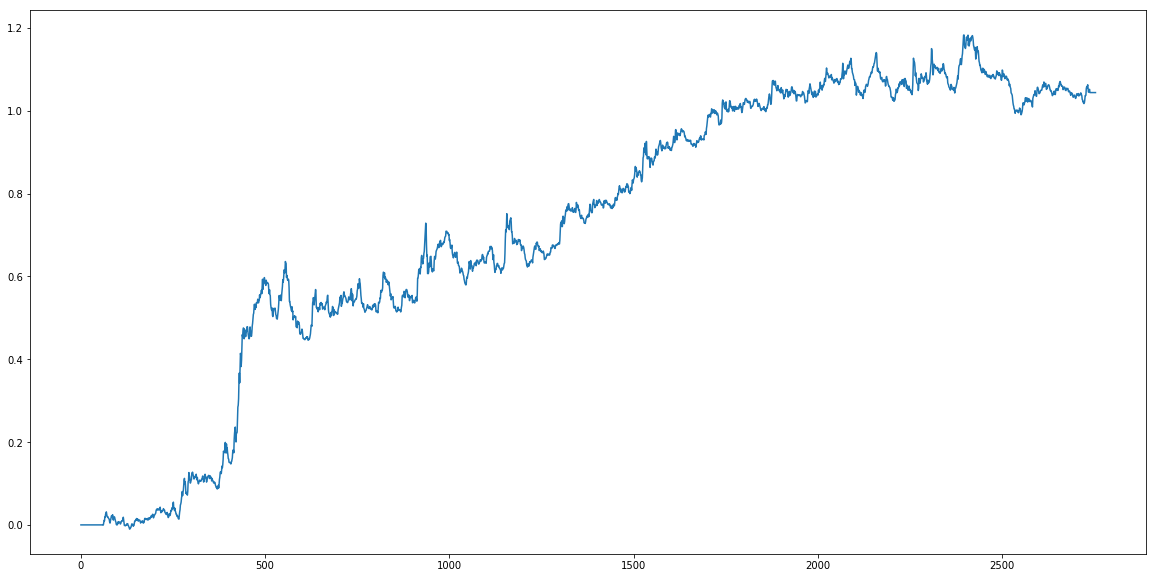

In [9]:
total_npv.plot(figsize=(20, 10))

In [10]:
t_sigma = 1e-3
R = 50

In [11]:
# using realized volatility
weight = np.zeros_like(NPV_df)
changed = False

for idx in range(len(NPV_df) - H):
    if idx < R:
        continue
    
    if idx % H == 0:
        vol = NPV_df.iloc[idx - R : idx, :].std(axis=0)
        if (vol == 0.0).any() or vol.hasnans:
            this_weight = np.ones((1, TOTAL_TYPE)) / TOTAL_TYPE
        else:
            this_weight = t_sigma / vol / TOTAL_TYPE #/ sum(index_vol[vol.index] * t_sigma / vol)
            if not changed:
                print("change to vol mode at:", idx)
                changed = True

        weight[idx : idx + H, :] = this_weight

positions["dpzbdl"] = weight / weight.mean()
total_npv = (positions["dpzbdl"] * NPV_df).sum(1).cumsum()

('change to vol mode at:', 2020)


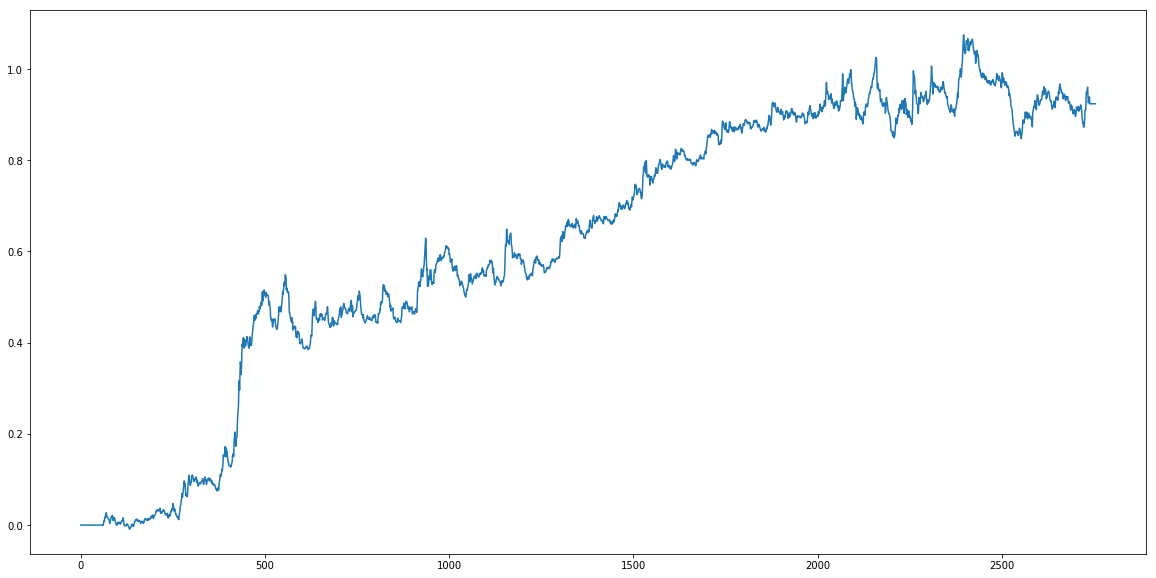

In [12]:
total_npv.plot(figsize=(20, 10))

组合波动率: 
$$\sigma_p = \sqrt{\sum_{i}{w_i^2 \sigma_i^2} + \sum_{i}\sum_{j}{w_i w_j \sigma_i \sigma_j} \rho_{ij}}$$  
假设通过对单策略使用目标波动率方法调节其杠杆，使得各个品种的波动率都为$\sigma_{tgt}$, 即:
$$\sigma_i = \sigma_{tgt}$$
把相同的波动率提取出来得到:
$$\sigma_p = \sigma_{tgt}\sqrt{1 / N + \rho_{mean}(N-1)/N}$$
故应该重新计算每个品种上的权重（杠杆)：
$$w_i = \sigma_{tgt} / (N \sigma_i) \sqrt{N / (1+\rho (N - 1))}$$
使得实际策略的波动率接近于目标波动率

In [13]:
t_sigma = 3e-4 # 注意到在相同的收益率水品的条件下，策略目标波动率方法的值要远小于单品种目标波动率的值。说明品种之间的相关性起了作用
R = 50
average_rho = 0.8

In [14]:
# using realized volatility
weight = np.zeros_like(NPV_df)
changed = False

for idx in range(len(NPV_df) - H):
    if idx < R:
        continue
    
    if idx % H == 0:
        vol = NPV_df.iloc[idx - R : idx, :].std(axis=0)
        
        price = NPV_df.iloc[idx - R : idx, :].values
        demean_price = price - price.mean(0)
        cov = demean_price.T.dot(demean_price)
        
        try:
            inv_std = np.sqrt(np.linalg.inv(np.eye(cov.shape[0]) * np.diag(cov)))
            corr_mean = inv_std.dot(cov).dot(inv_std).mean()
        except:
            corr_mean = average_rho
        
        if (vol == 0.0).any() or vol.hasnans:
            this_weight = np.ones((1, TOTAL_TYPE)) / TOTAL_TYPE
        else:
            this_weight = t_sigma * sqrt(TOTAL_TYPE / (1 + corr_mean * (TOTAL_TYPE - 1))) / vol / TOTAL_TYPE 
            if not changed:
                print("change to vol mode at:", idx)
                changed = True

        weight[idx : idx + H, :] = this_weight

positions["clbdl"] = weight / weight.mean()
total_npv = (positions["clbdl"] * NPV_df).sum(1).cumsum()

('change to vol mode at:', 2020)


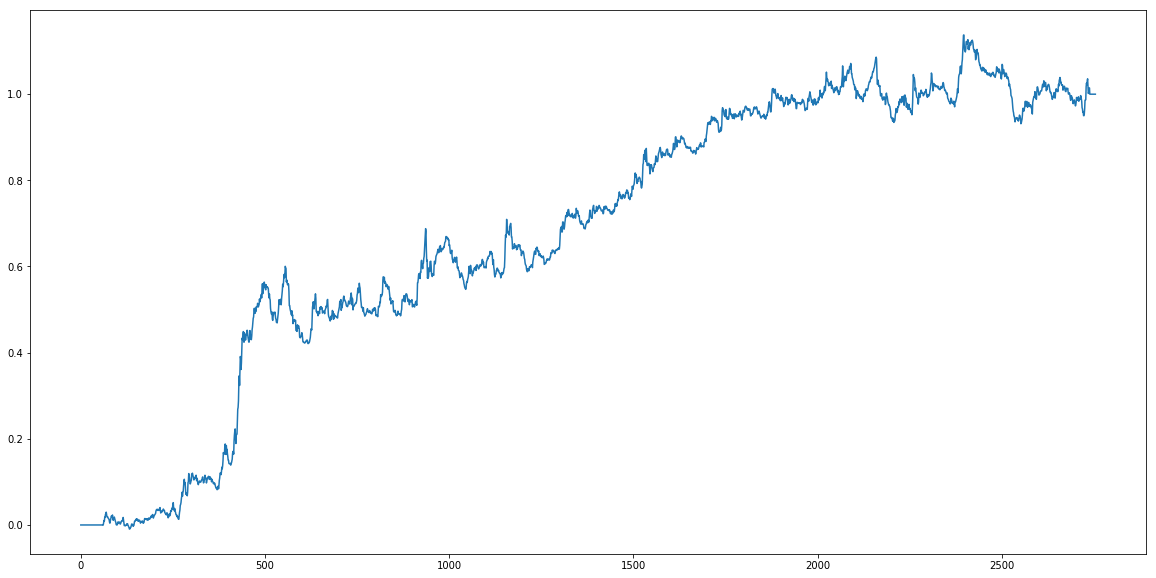

In [15]:
total_npv.plot(figsize=(20, 10))

In [16]:
position = positions["bdlds"]

In [17]:
S = 5
L = 20
lag = 2
R = 50
position_level = [0.9, 1.1]

In [18]:
individual_npv = (position * NPV_df).cumsum()
rolling_ma_5 = lambda x: x.rolling(S).mean()
rolling_ma_20 = lambda x: x.rolling(L).mean()
short_ma = NPV_df.apply(rolling_ma_5)
long_ma = NPV_df.apply(rolling_ma_20)
this_NPV = NPV_df.copy()
this_NPV[(short_ma > long_ma).shift(lag).fillna(False)] = this_NPV[(short_ma > long_ma).shift(lag).fillna(False)] * position_level[1]
this_NPV[(short_ma < long_ma).shift(lag).fillna(False)] = this_NPV[(short_ma < long_ma).shift(lag).fillna(False)] * position_level[0]
average_position = (this_NPV / NPV_df).mean().mean()
print("average position:", average_position)

('average position:', 1.0010355807840912)


In [19]:
total_npv = this_NPV.cumsum().sum(1) / average_position # 需要对平均仓位进行调整，否则可能会是由于整体杠杆高而使得收益率高。

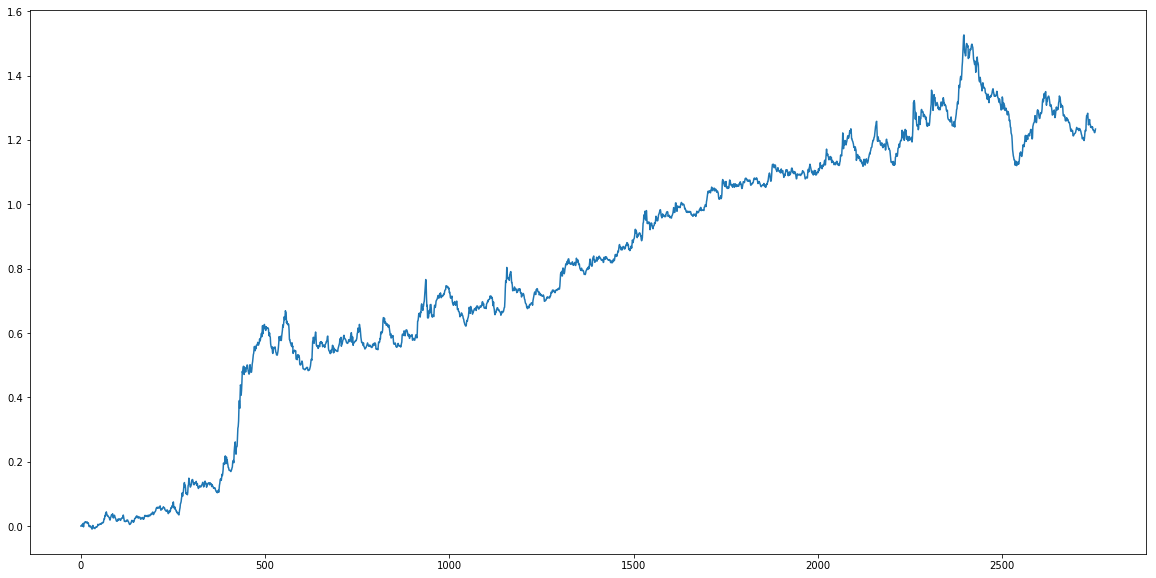

In [20]:
total_npv.plot(figsize=(20, 10))

In [21]:
ar = np.random.random((1, 3))

In [22]:
def regress(y1, y2):
    y2 = np.hstack((np.ones_like(y2), y2))
    return np.linalg.inv(y2.T.dot(y2)).dot(y2.T).dot(y1)

def rolling_regress(y1, y2, lag):
    beta = np.zeros((len(y1), 2))
    for idx in xrange(len(beta)):
        if idx < lag:
            continue
        beta[idx, :] = regress(y1[idx - lag : idx], y2[idx - lag : idx]).T
    
    return beta

def rolling_order_regress(y1, y2, lag):
    y1_od = y1.argsort()
    y2_od = y2.argsort()
    return rolling_regress(y1_od, y2_od, lag) 

$$\pi^*(t) = \frac{1}{1-\gamma} \frac{\mu - r}{\sigma^2}$$
where$U(x) = \frac{1}{\gamma}x^\gamma$

In [23]:
G = 2
H = 5
R = 50
r = 0.03

In [48]:
# 使用历史波动率
weight = np.zeros_like(NPV_df)
changed = False

for idx in range(len(NPV_df) - H):
    if idx < R:
        continue
    
    if idx % H == 0:
        vol = NPV_df.iloc[idx - R : idx, :].std(axis=0)
        u = NPV_df.iloc[idx - R : idx, :].mean(axis=0)
        
        if (vol == np.nan).any() or (vol <= 0.0).any():
            this_weight = np.ones((1, TOTAL_TYPE)) / TOTAL_TYPE
        else:
            if not changed:
                print("change to vol mode at:", idx)
                changed = True
            this_weight = 1 /(1 - G) * (u - r) / vol**2
            this_weight = this_weight / sum(this_weight)
        
        weight[idx : idx + H, :] = this_weight

positions["bdlds"] = weight / weight.mean()
total_npv = (positions["bdlds"] * NPV_df).sum(1).cumsum()

('change to vol mode at:', 2005)


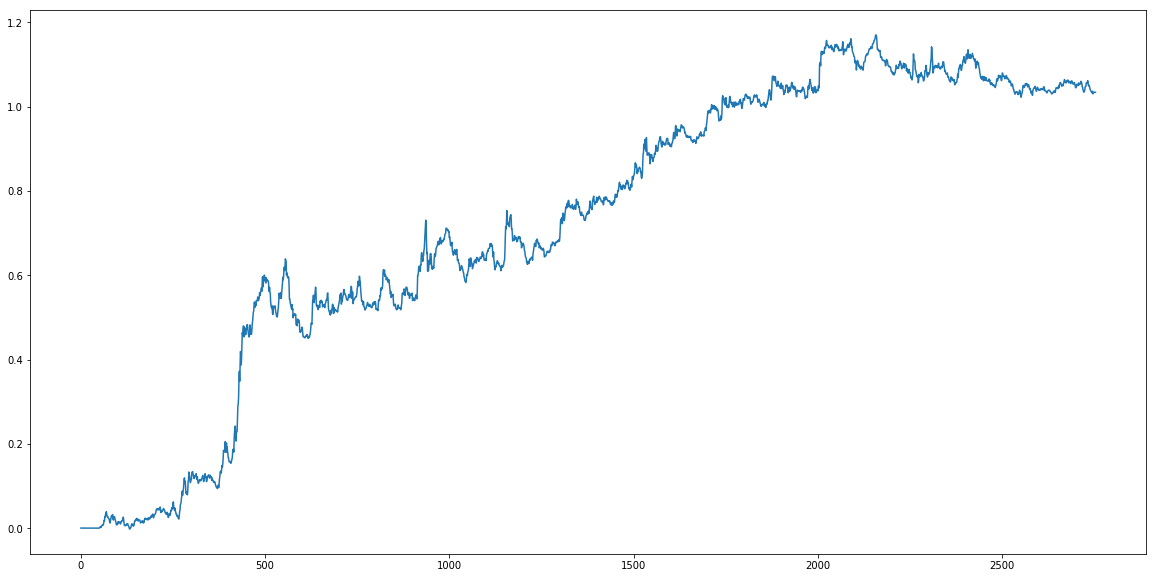

In [63]:
total_npv.plot(figsize=(20, 10))

In [55]:
def optimize_target(G):
    weight = np.zeros_like(NPV_df)
    changed = False

    for idx in range(len(NPV_df) - H):
        if idx < R:
            continue

        if idx % H == 0:
            vol = NPV_df.iloc[idx - R : idx, :].std(axis=0)
            u = NPV_df.iloc[idx - R : idx, :].mean(axis=0)

            if (vol == np.nan).any() or (vol <= 0.0).any():
                this_weight = np.ones((1, TOTAL_TYPE)) / TOTAL_TYPE
            else:
                if not changed:
                    #print("change to vol mode at:", idx)
                    changed = True
                this_weight = 1 /(1 - G) * (u - r) / vol**2
                this_weight = this_weight / sum(this_weight)

            weight[idx : idx + H, :] = this_weight

    positions["bdlds"] = weight / weight.mean()
    return ((positions["bdlds"] * NPV_df).sum(1).cumsum().iloc[-1], G)

In [ ]:
args = [i / 10.0 for i in xrange(2, 100001, 10)]
result = map(optimize_target, args)
result.sort(key=lambda x: x[1], reverse=True)

In [ ]:
result